In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
# import dataset
from torch.utils.data import DataLoader, Dataset
# import pad sequence
import numpy as np
import os
import numpy as np
import librosa
from sklearn.metrics import recall_score, f1_score, precision_score, accuracy_score
from sklearn.model_selection import train_test_split, KFold
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import classification_report

avarage = 'micro'

In [ ]:
class Attention(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, groups=1, reduction=0.0625, kernel_num=4, min_channel=16):
        super(Attention, self).__init__()
        attention_channel = max(int(in_planes * reduction), min_channel)
        self.kernel_size = kernel_size
        self.kernel_num = kernel_num
        self.temperature = 1.0

        self.avgpool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Conv2d(in_planes, attention_channel, 1, bias=False)
        self.bn = nn.BatchNorm2d(attention_channel)
        self.relu = nn.ReLU(inplace=True)

        self.channel_fc = nn.Conv2d(attention_channel, in_planes, 1, bias=True)
        self.func_channel = self.get_channel_attention

        if in_planes == groups and in_planes == out_planes:  # depth-wise convolution
            self.func_filter = self.skip
        else:
            self.filter_fc = nn.Conv2d(attention_channel, out_planes, 1, bias=True)
            self.func_filter = self.get_filter_attention

        if kernel_size == 1:  # point-wise convolution
            self.func_spatial = self.skip
        else:
            self.spatial_fc = nn.Conv2d(attention_channel, kernel_size * kernel_size, 1, bias=True)
            self.func_spatial = self.get_spatial_attention

        if kernel_num == 1:
            self.func_kernel = self.skip
        else:
            self.kernel_fc = nn.Conv2d(attention_channel, kernel_num, 1, bias=True)
            self.func_kernel = self.get_kernel_attention

        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            if isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def update_temperature(self, temperature):
        self.temperature = temperature

    @staticmethod
    def skip(_):
        return 1.0

    def get_channel_attention(self, x):
        channel_attention = torch.sigmoid(self.channel_fc(x).view(x.size(0), -1, 1, 1) / self.temperature)
        return channel_attention

    def get_filter_attention(self, x):
        filter_attention = torch.sigmoid(self.filter_fc(x).view(x.size(0), -1, 1, 1) / self.temperature)
        return filter_attention

    def get_spatial_attention(self, x):
        spatial_attention = self.spatial_fc(x).view(x.size(0), 1, 1, 1, self.kernel_size, self.kernel_size)
        spatial_attention = torch.sigmoid(spatial_attention / self.temperature)
        return spatial_attention

    def get_kernel_attention(self, x):
        kernel_attention = self.kernel_fc(x).view(x.size(0), -1, 1, 1, 1, 1)
        kernel_attention = F.softmax(kernel_attention / self.temperature, dim=1)
        return kernel_attention

    def forward(self, x):
        x = self.avgpool(x)
        x = self.fc(x)
        x = self.bn(x)
        x = self.relu(x)
        return self.func_channel(x), self.func_filter(x), self.func_spatial(x), self.func_kernel(x)


class ODConv2d(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1,
                 reduction=0.0625, kernel_num=4):
        super(ODConv2d, self).__init__()
        self.in_planes = in_planes
        self.out_planes = out_planes
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.dilation = dilation
        self.groups = groups
        self.kernel_num = kernel_num
        self.attention = Attention(in_planes, out_planes, kernel_size, groups=groups,
                                   reduction=reduction, kernel_num=kernel_num)
        self.weight = nn.Parameter(torch.randn(kernel_num, out_planes, in_planes//groups, kernel_size, kernel_size),
                                   requires_grad=True)
        self._initialize_weights()

        if self.kernel_size == 1 and self.kernel_num == 1:
            self._forward_impl = self._forward_impl_pw1x
        else:
            self._forward_impl = self._forward_impl_common

    def _initialize_weights(self):
        for i in range(self.kernel_num):
            nn.init.kaiming_normal_(self.weight[i], mode='fan_out', nonlinearity='relu')

    def update_temperature(self, temperature):
        self.attention.update_temperature(temperature)

    def _forward_impl_common(self, x):
        # Multiplying channel attention (or filter attention) to weights and feature maps are equivalent,
        # while we observe that when using the latter method the models will run faster with less gpu memory cost.
        channel_attention, filter_attention, spatial_attention, kernel_attention = self.attention(x)
        batch_size, in_planes, height, width = x.size()
        x = x * channel_attention
        x = x.reshape(1, -1, height, width)
        aggregate_weight = spatial_attention * kernel_attention * self.weight.unsqueeze(dim=0)
        aggregate_weight = torch.sum(aggregate_weight, dim=1).view(
            [-1, self.in_planes // self.groups, self.kernel_size, self.kernel_size])
        output = F.conv2d(x, weight=aggregate_weight, bias=None, stride=self.stride, padding=self.padding,
                          dilation=self.dilation, groups=self.groups * batch_size)
        output = output.view(batch_size, self.out_planes, output.size(-2), output.size(-1))
        output = output * filter_attention
        return output

    def _forward_impl_pw1x(self, x):
        channel_attention, filter_attention, spatial_attention, kernel_attention = self.attention(x)
        x = x * channel_attention
        output = F.conv2d(x, weight=self.weight.squeeze(dim=0), bias=None, stride=self.stride, padding=self.padding,
                          dilation=self.dilation, groups=self.groups)
        output = output * filter_attention
        return output

    def forward(self, x):
        return self._forward_impl(x)

In [ ]:
class BasicConv(nn.Module):
    def __init__(self, in_planes, out_planes, kernel_size, stride=1, padding=0, dilation=1, groups=1, relu=True, bn=True, bias=False):
        super(BasicConv, self).__init__()
        self.out_channels = out_planes
        self.conv = ODConv2d(in_planes, out_planes, kernel_size=kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups)
        self.bn = nn.BatchNorm2d(out_planes,eps=1e-5, momentum=0.01, affine=True) if bn else None
        self.relu = nn.ReLU() if relu else None

    def forward(self, x):
        x = self.conv(x)
        if self.bn is not None:
            x = self.bn(x)
        if self.relu is not None:
            x = self.relu(x)
        return x

class Flatten(nn.Module):
    def forward(self, x):
        return x.view(x.size(0), -1)

class ChannelGate(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max']):
        super(ChannelGate, self).__init__()
        self.gate_channels = gate_channels
        self.mlp = nn.Sequential(
            Flatten(),
            nn.Linear(gate_channels, gate_channels // reduction_ratio),
            nn.ReLU(),
            nn.Linear(gate_channels // reduction_ratio, gate_channels)
            )
        self.pool_types = pool_types
    def forward(self, x):
        channel_att_sum = None
        for pool_type in self.pool_types:
            if pool_type=='avg':
                avg_pool = F.avg_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( avg_pool )
            elif pool_type=='max':
                max_pool = F.max_pool2d( x, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( max_pool )
            elif pool_type=='lp':
                lp_pool = F.lp_pool2d( x, 2, (x.size(2), x.size(3)), stride=(x.size(2), x.size(3)))
                channel_att_raw = self.mlp( lp_pool )
            elif pool_type=='lse':
                # LSE pool only
                lse_pool = logsumexp_2d(x)
                channel_att_raw = self.mlp( lse_pool )

            if channel_att_sum is None:
                channel_att_sum = channel_att_raw
            else:
                channel_att_sum = channel_att_sum + channel_att_raw

        scale = F.sigmoid( channel_att_sum ).unsqueeze(2).unsqueeze(3).expand_as(x)
        return x * scale

def logsumexp_2d(tensor):
    tensor_flatten = tensor.view(tensor.size(0), tensor.size(1), -1)
    s, _ = torch.max(tensor_flatten, dim=2, keepdim=True)
    outputs = s + (tensor_flatten - s).exp().sum(dim=2, keepdim=True).log()
    return outputs

class ChannelPool(nn.Module):
    def forward(self, x):
        return torch.cat( (torch.max(x,1)[0].unsqueeze(1), torch.mean(x,1).unsqueeze(1)), dim=1 )

class SpatialGate(nn.Module):
    def __init__(self):
        super(SpatialGate, self).__init__()
        kernel_size = 7
        self.compress = ChannelPool()
        self.spatial = ODConv2d(2, 1, kernel_size, stride=1, padding=(kernel_size-1) // 2)
    def forward(self, x):
        x_compress = self.compress(x)
        x_out = self.spatial(x_compress)
        scale = F.sigmoid(x_out) # broadcasting
        return x * scale

class CBAM(nn.Module):
    def __init__(self, gate_channels, reduction_ratio=16, pool_types=['avg', 'max'], no_spatial=False):
        super(CBAM, self).__init__()
        self.ChannelGate = ChannelGate(gate_channels, reduction_ratio, pool_types)
        self.no_spatial=no_spatial
        if not no_spatial:
            self.SpatialGate = SpatialGate()
    def forward(self, x):
        x_out = self.ChannelGate(x)
        if not self.no_spatial:
            x_out = self.SpatialGate(x_out)
        return x_out

In [ ]:
class Dual(nn.Module):
    def __init__(self):
        super(Dual, self).__init__()

        # self.feature_extractor1 = nn.Sequential(
        #     # 1st Conv Layer + BatchNorm + ReLU + Pooling
        #     nn.Conv1d(in_channels=1, out_channels=64, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm1d(64),
        #     nn.ReLU(),
        #     nn.MaxPool1d(kernel_size=4, stride=4),

        #     # 2nd Conv Layer + BatchNorm + ReLU + Pooling
        #     nn.Conv1d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm1d(128),
        #     nn.ReLU(),
        #     nn.MaxPool1d(kernel_size=4, stride=4),

        #     # 3rd Conv Layer + BatchNorm + ReLU + Pooling
        #     nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm1d(128),
        #     nn.ReLU(),
        #     nn.MaxPool1d(kernel_size=4, stride=4),

        #     # 4th Conv Layer + BatchNorm + ReLU + Pooling
        #     nn.Conv1d(in_channels=128, out_channels=128, kernel_size=3, stride=1, padding=1),
        #     nn.BatchNorm1d(128),
        #     nn.ReLU(),
        #     nn.MaxPool1d(kernel_size=4, stride=4)
        # )

        # self.lstm = nn.LSTM(input_size=128, hidden_size=256, batch_first=True)
        # # out put lstm (batch_size, seq_len, hidden_size) (batch_size, 1, 256)
        # self.fc1 = nn.Linear(256, 5)

        self.feature_extractor2 = nn.Sequential(
            # 1st Conv Layer + BatchNorm + ReLU + Pooling
            nn.Conv2d(in_channels=1, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1),  # (128, 251) -> (128, 251, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(2, 2), stride=(2, 2)),  # (128, 251, 64) -> (64, 125, 64)

            # 2nd Conv Layer + BatchNorm + ReLU + Pooling
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=(3, 3), stride=(1, 1), padding=1),  # (64, 125, 64) -> (64, 125, 64)
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=(4, 4)),  # (64, 125, 64) -> (16, 31, 64)

            # 3rd Conv Layer + BatchNorm + ReLU + Pooling
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1),  # (16, 31, 64) -> (16, 31, 128)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=(4, 4)),  # (16, 31, 128) -> (4, 7, 128)

            # 4th Conv Layer + BatchNorm + ReLU + Pooling
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=(3, 3), stride=(1, 1), padding=1),  # (4, 7, 128) -> (4, 7, 128)
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(4, 4), stride=(4, 4))  # (4, 7, 128) -> (1, 1, 128)
        )

        # Fully Connected Layer
        self.fc2 = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256, 512),  # 1*1*128 -> 256
            nn.ReLU(),
            nn.Linear(512, 5),  # 256 -> 5
        )

        # self.truefc = nn.Softmax(dim=1)
        self.gru = nn.GRU(input_size=128, hidden_size=256, bidirectional=False, batch_first=True)
        self.fc3 = nn.Linear(5, 5)
        self.cbam = CBAM(128)

    def forward(self, mfcc):
        # wave_form = self.feature_extractor1(wave_form)  # Pass through the sequential feature extractor

        # # LSTM expects input of shape (batch_size, seq_len, input_size)
        # wave_form = wave_form.permute(0, 2, 1)  # Reshape to (batch_size, seq_len, input_size)
        # wave_form, _ = self.lstm(wave_form)

        # wave_form = wave_form[:, -1, :]

        # wave_form = self.fc1(wave_form)

        mfcc = self.feature_extractor2(mfcc)
        mfcc = self.cbam(mfcc)
        mfcc = mfcc.squeeze().unsqueeze(1)

        mfcc,_ = self.gru(mfcc)
        mfcc = self.fc2(mfcc)
        # x = torch.cat((wave_form, mfcc), dim=1)

        mfcc = self.fc3(mfcc)

        return mfcc


In [ ]:
n_mfcc = 128
window_size = 2048
strides = 512
window_size_stft = 1024
window = np.hanning(window_size_stft)

def load_emodata(link, sr = 16000, duration = 5):
    # Load the audio file
    wave_form, _ = librosa.load(path=link, sr=sr)
    # label = father folder name
    labels = os.path.basename(os.path.dirname(link))

    if len(wave_form) < sr * duration:
        # zero pad the audio if its less than 5 seconds
        wave_form = np.pad(wave_form, (0, sr * duration - len(wave_form)), 'symmetric')
        mfcc1 = librosa.feature.mfcc(y=wave_form, sr=8000, n_mfcc=n_mfcc, n_fft=window_size, hop_length=strides)
        # stft1 = librosa.core.spectrum.stft(wave_form, n_fft=window_size_stft, hop_length=256, window=window)
        # spect1 = 2 * np.abs(stft1) / np.sum(window)
        return np.array([mfcc1]), np.array([labels])

    elif len(wave_form) == sr * duration:
        mfcc2 = librosa.feature.mfcc(y=wave_form, sr=8000, n_mfcc=n_mfcc, n_fft=window_size, hop_length=strides)
        # stft2 = librosa.core.spectrum.stft(wave_form, n_fft=window_size_stft, hop_length=256, window=window)
        # spect2 = 2 * np.abs(stft2) / np.sum(window)
        # return the audio as it is
        return np.array([mfcc2]), np.array([labels])


    else:
        wave_segments = []
        _labels = [labels] * (len(wave_form) // (sr * duration) + 1)
        for i in range(0, len(wave_form), sr * duration):
            wave_segments.append(wave_form[i:i + sr * duration])

        # If the last segment is less than 5 seconds, then pad it with the last 5 seconds of the second last segment
        len_wave_segments_last = len(wave_segments[-1])
        padding = sr * duration - len_wave_segments_last
        temp = np.append(wave_segments[-2][sr * duration - padding:], wave_segments[-1])
        wave_segments[-1] = temp

        mfcc_seg = librosa.feature.mfcc(y=np.array(wave_segments), sr=8000, n_mfcc=n_mfcc, n_fft=window_size, hop_length=strides)
        # stft_seg = librosa.core.spectrum.stft(wave_segments, n_fft=window_size_stft, hop_length=256, window=window)
        # spect_seg = 2 * np.abs(stft_seg) / np.sum(window)

        return np.array(mfcc_seg) , np.array(_labels)

In [ ]:
data_folder = "../VNEMOS/"

In [ ]:
def load_data(data_folder):
    # waves = []
    mfccs = []
    labels = []
    for root, dirs, files in os.walk(data_folder):
        for file in files:
            if file.endswith(".wav"):
                link = os.path.join(root, file)
                mfcc, label = load_emodata(link)

                # waves.extend(wave)
                mfccs.extend(mfcc)
                labels.extend(label)

    return np.array(mfccs), np.array(labels)

In [ ]:
mfccs, labels = load_data(data_folder)

In [ ]:
len(mfccs), len(labels)

(528, 528)

In [ ]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

In [ ]:
class EmoDataset(Dataset):
    def __init__(self, mfccs, labels):

        self.mfccs = mfccs
        self.labels = labels

    def __len__(self):
        return len(self.mfccs)

    def __getitem__(self, index):
        return self.mfccs[index], self.labels[index]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
EMO_CLASSES = {label: i for i, label in enumerate(np.unique(labels))}

In [ ]:
EMO_CLASSES

{'angry': 0, 'fear': 1, 'happiness': 2, 'neutral': 3, 'sadness': 4}

In [ ]:
for idx, (train_idx, test_idx) in enumerate(skf.split(mfccs, labels)):

    # wave_train, wave_test = waves[train_idx], waves[test_idx]
    mfcc_train, mfcc_test = mfccs[train_idx], mfccs[test_idx]
    train_labels, test_labels = labels[train_idx], labels[test_idx]

    train_labels = [EMO_CLASSES[label] for label in train_labels]
    test_labels = [EMO_CLASSES[label] for label in test_labels]


    train_dataset = EmoDataset(mfcc_train, train_labels)
    test_dataset = EmoDataset(mfcc_test, test_labels)

    print("Train data: ", Counter(train_labels))
    print("Test data: ", Counter(test_labels))


Train data:  Counter({4: 108, 2: 97, 3: 88, 0: 66, 1: 63})
Test data:  Counter({4: 26, 2: 25, 3: 22, 0: 17, 1: 16})
Train data:  Counter({4: 107, 2: 97, 3: 88, 0: 66, 1: 64})
Test data:  Counter({4: 27, 2: 25, 3: 22, 0: 17, 1: 15})
Train data:  Counter({4: 107, 2: 98, 3: 88, 0: 66, 1: 63})
Test data:  Counter({4: 27, 2: 24, 3: 22, 0: 17, 1: 16})
Train data:  Counter({4: 107, 2: 98, 3: 88, 0: 67, 1: 63})
Test data:  Counter({4: 27, 2: 24, 3: 22, 1: 16, 0: 16})
Train data:  Counter({4: 107, 2: 98, 3: 88, 0: 67, 1: 63})
Test data:  Counter({4: 27, 2: 24, 3: 22, 1: 16, 0: 16})


In [ ]:
epochs = 100
batch_size = 32
learning_rate = 0.001
loss_fn = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
EMO_CLASSES = {label: i for i, label in enumerate(set(labels))}

In [ ]:
acc_kfold = []
f1_kfold = []
recall_kfold = []
precision_kfold = []
data_kfold = []
labels_preds_kfold = []

In [ ]:
for idx, (train_idx, test_idx) in enumerate(skf.split(mfccs, labels)):

    mfcc_train, mfcc_test = mfccs[train_idx], mfccs[test_idx]
    train_labels, test_labels = labels[train_idx], labels[test_idx]

    train_labels = [EMO_CLASSES[label] for label in train_labels]
    test_labels = [EMO_CLASSES[label] for label in test_labels]


    train_dataset = EmoDataset(mfcc_train, train_labels)
    test_dataset = EmoDataset(mfcc_test, test_labels)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = Dual()
    model.to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    best_acc = 0
    best_f1 = 0
    best_recall = 0
    best_precision = 0

    acc = []
    f1 = []
    recall = []
    precision = []
    best_labels_preds = []

    for epoch in range(epochs):
        tt_loss = 0
        model.train()
        for mfcc, label in train_loader:

            mfcc = mfcc.unsqueeze(1).to(device)
            label = label.to(device)

            optimizer.zero_grad()
            output = model(mfcc)

            loss = loss_fn(output, label)
            loss.backward()
            optimizer.step()
            tt_loss += loss.item()

        print("K-Fold: ", idx, "Epoch: ", epoch, "Train loss: ", tt_loss / len(train_loader))

        model.eval()

        with torch.no_grad():
            all_labels = []
            all_preds = []

            for mfcc, label in test_loader:

                mfcc = mfcc.unsqueeze(1).to(device)
                label = label.to(device)

                output = model(mfcc)
                _, predicted = torch.max(output, 1)

                all_labels.extend(label.cpu().numpy())
                all_preds.extend(predicted.cpu().numpy())


            validation_acc = accuracy_score(all_labels, all_preds)
            recall_val = recall_score(all_labels, all_preds, average=avarage)
            f1_val = f1_score(all_labels, all_preds, average=avarage)
            precision_val = precision_score(all_labels, all_preds, average=avarage)

            acc.append(validation_acc)
            f1.append(f1_val)
            recall.append(recall_val)
            precision.append(precision_val)


            if validation_acc > best_acc:
                best_acc = validation_acc
                best_recall = recall_val
                best_f1 = f1_val
                best_precision = precision_val
                best_labels_preds = [all_labels, all_preds]

                # torch.save(model.state_dict(), f"best_model_{idx}.pth")

            print(f"K-Fold: {idx}, Epoch: {epoch}, Accuracy: {validation_acc}, Recall: {recall_val}, F1: {f1_val}, Precision: {precision_val}")

    data_kfold.append([acc, f1, recall, precision])

    acc_kfold.append(best_acc)
    f1_kfold.append(best_f1)
    recall_kfold.append(best_recall)
    precision_kfold.append(best_precision)
    labels_preds_kfold.append(best_labels_preds)


K-Fold:  0 Epoch:  0 Train loss:  1.5622512783323015
K-Fold: 0, Epoch: 0, Accuracy: 0.3867924528301887, Recall: 0.3867924528301887, F1: 0.38679245283018876, Precision: 0.3867924528301887
K-Fold:  0 Epoch:  1 Train loss:  1.3775563410350256
K-Fold: 0, Epoch: 1, Accuracy: 0.330188679245283, Recall: 0.330188679245283, F1: 0.330188679245283, Precision: 0.330188679245283
K-Fold:  0 Epoch:  2 Train loss:  1.2603134725775038
K-Fold: 0, Epoch: 2, Accuracy: 0.39622641509433965, Recall: 0.39622641509433965, F1: 0.39622641509433965, Precision: 0.39622641509433965
K-Fold:  0 Epoch:  3 Train loss:  1.2783999698502677
K-Fold: 0, Epoch: 3, Accuracy: 0.4528301886792453, Recall: 0.4528301886792453, F1: 0.4528301886792453, Precision: 0.4528301886792453
K-Fold:  0 Epoch:  4 Train loss:  1.135295889207295
K-Fold: 0, Epoch: 4, Accuracy: 0.4056603773584906, Recall: 0.4056603773584906, F1: 0.4056603773584906, Precision: 0.4056603773584906
K-Fold:  0 Epoch:  5 Train loss:  1.0594872832298279
K-Fold: 0, Epoch:

In [ ]:
len(data_kfold)

5

In [ ]:
len(labels_preds_kfold)

5

In [ ]:
def print_classification_report(labels_preds_kfold):
    for idx, data in enumerate(labels_preds_kfold):
        print(f"K-Fold: {idx}")
        print(classification_report(data[0], data[1], target_names=EMO_CLASSES.keys()))

In [ ]:
def plot_metrics(data_kfold):
    num_folds = len(data_kfold)
    plt.figure(figsize=(20, 5))

    for idx, data in enumerate(data_kfold):
        acc, f1, recall, precision = data
        plt.subplot(1, num_folds, idx + 1)
        plt.plot(acc, label='Accuracy')
        plt.plot(recall, label='Recall')
        plt.plot(f1, label='F1')
        plt.plot(precision, label='Precision')
        plt.title(f"K-Fold {idx + 1}")
        plt.xlabel('Epochs')
        plt.ylabel('Metrics')
        plt.ylim(0.0, 1.0)  # Set y-axis range from 0.0 to 1.0
        plt.legend()
        plt.grid(True)

    plt.tight_layout()  # Adjust subplots to fit into figure area
    plt.show()

In [ ]:
acc_kfold

[0.8113207547169812,
 0.8207547169811321,
 0.8962264150943396,
 0.9142857142857143,
 0.8952380952380953]

In [ ]:
np.mean(acc_kfold),np.mean(f1_kfold),np.mean(precision_kfold),np.mean(f1_kfold)

(0.8675651392632526,
 0.8675651392632526,
 0.8675651392632526,
 0.8675651392632526)

In [ ]:
print_classification_report(labels_preds_kfold)

K-Fold: 0
              precision    recall  f1-score   support

     sadness       0.83      0.73      0.78        26
     neutral       0.84      0.95      0.89        22
   happiness       0.71      0.80      0.75        25
        fear       0.87      0.81      0.84        16
       angry       0.87      0.76      0.81        17

    accuracy                           0.81       106
   macro avg       0.82      0.81      0.82       106
weighted avg       0.82      0.81      0.81       106

K-Fold: 1
              precision    recall  f1-score   support

     sadness       0.86      0.93      0.89        27
     neutral       0.84      0.95      0.89        22
   happiness       0.77      0.68      0.72        25
        fear       0.87      0.87      0.87        15
       angry       0.73      0.65      0.69        17

    accuracy                           0.82       106
   macro avg       0.81      0.81      0.81       106
weighted avg       0.82      0.82      0.82       106

K-

In [ ]:
# average classification report
def average_classification_report(labels_preds_kfold):
    all_labels = []
    all_preds = []
    for data in labels_preds_kfold:
        all_labels.extend(data[0])
        all_preds.extend(data[1])
    print(classification_report(all_labels, all_preds, target_names=EMO_CLASSES.keys()))

In [ ]:
average_classification_report(labels_preds_kfold)

              precision    recall  f1-score   support

     sadness       0.90      0.90      0.90       134
     neutral       0.91      0.93      0.92       110
   happiness       0.80      0.86      0.83       122
        fear       0.90      0.78      0.84        79
       angry       0.85      0.82      0.83        83

    accuracy                           0.87       528
   macro avg       0.87      0.86      0.86       528
weighted avg       0.87      0.87      0.87       528



In [ ]:
# plot confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns


def plot_confusion_matrix(labels_preds_kfold):
    all_labels = []
    all_preds = []
    for data in labels_preds_kfold:
        all_labels.extend(data[0])
        all_preds.extend(data[1])

    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=EMO_CLASSES.keys(), yticklabels=EMO_CLASSES.keys())
    plt.xlabel('Predicted labels')
    plt.ylabel('True labels')
    plt.title('Confusion Matrix')
    plt.show()


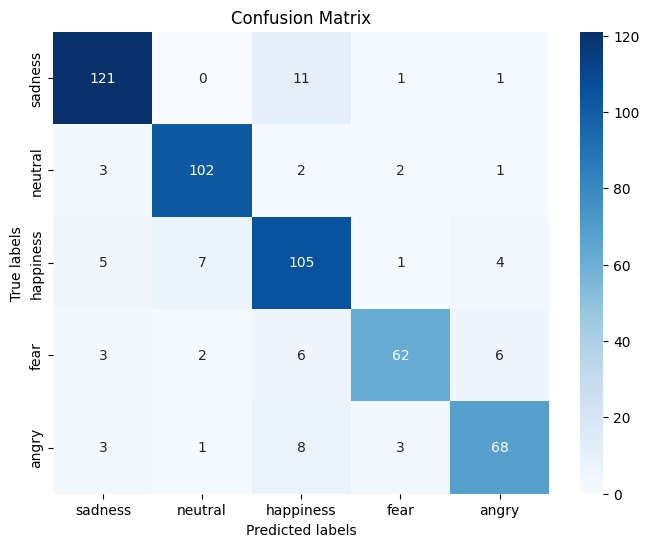

In [ ]:
plot_confusion_matrix(labels_preds_kfold)

In [ ]:
def compute_ua_wa(labels_preds_kfold):
    true_labels = np.array([])
    predicted_labels = np.array([])

    # Gộp tất cả nhãn thực và nhãn dự đoán từ các fold
    for data in labels_preds_kfold:
        true_labels = np.append(true_labels, data[0])
        predicted_labels = np.append(predicted_labels, data[1])

    # Tính UA (Unweighted Accuracy)
    ua = accuracy_score(true_labels, predicted_labels)

    # Tính WA (Weighted Accuracy)
    wa = []
    for label in np.unique(true_labels):
        i_true = true_labels[true_labels == label]
        i_predicted = predicted_labels[true_labels == label]

        wa.append(np.sum(i_true == i_predicted) / len(i_true))
    wa = np.mean(wa)
    return ua, wa

In [ ]:
ua, wa = compute_ua_wa(labels_preds_kfold)
print(f"Unweighted Accuracy: {ua}, Weighted Accuracy: {wa}")

Unweighted Accuracy: 0.8674242424242424, Weighted Accuracy: 0.8590001549241049
